In [1]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision.utils import save_image,make_grid
import torchvision.datasets as datasets
import torch.utils.data as data_utils
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import metrics

from tqdm.notebook import tqdm as tqdm
import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np
import shutil
import pickle
import os

import cv2

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

# torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

Using PyTorch version: 2.1.0.dev20230622+cu121  Device: cuda


In [3]:
dataset_name = "cifar"

if dataset_name == "cifar":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar"
    dataset_nonfourier_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\cifar"
    
if dataset_name == "mnist":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\mnist" 

In [4]:
## For loading label names, only applicable for cifar10 

if dataset_name == "cifar":
    
    with open(os.path.join(dataset_path,"datasets","cifar-10-batches-py\\batches.meta"), 'rb') as fp:
        label_names = pickle.load(fp)['label_names']

In [35]:
# For loading labels for the dataset

with open(os.path.join(dataset_path,"datasets",dataset_name+"_labels"), 'rb') as fp:
    targets = pickle.load(fp)

with open(os.path.join(dataset_nonfourier_path,"datasets",dataset_name+"_labels"), 'rb') as fp:
    targets_nonfourier = pickle.load(fp)

targets = np.array(targets) ##new
targets_nonfourier = np.array(targets_nonfourier) ##new

## Moving Dataset paths

In [ ]:
# for i in label_names:

#     os.makedirs(os.path.join(dataset_path,"reconst_class_images",i))

In [ ]:
# for i in range(10000):

#     tg = targets[i]
#     shutil.copy(os.path.join(dataset_path,"reconstructed_images",str(i)+".png"),os.path.join(dataset_path,"reconst_class_images",label_names[tg],str(i)+".png"))
#     # print(os.path.join(dataset_path,"reconstructed_images",str(i)+".png"),os.path.join(dataset_path,"reconst_class_images",label_names[tg],str(i)+".png"))
    

## Loading Dataset

### Reconstructed Images (with Fourier)

In [6]:
input_raw_list = []

In [7]:
for i in range(10000):

    img = cv2.imread(os.path.join(dataset_path,"reconstructed_images",str(i)+".png"),cv2.IMREAD_GRAYSCALE)
    img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    input_raw_list.append(img)


In [8]:
input_reconst = np.array(input_raw_list)

### Reconstructed Images (without Fourier)

In [36]:
input_nonfourier_list = []

In [37]:
for i in range(10000):

    img = cv2.imread(os.path.join(dataset_nonfourier_path,"reconstructed_images",str(i)+".png"),cv2.IMREAD_GRAYSCALE)
    img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    input_nonfourier_list.append(img)


In [38]:
input_reconst_nonfourier = np.array(input_nonfourier_list)

In [39]:
input_reconst_nonfourier.shape

(10000, 28, 28)

### Original Images

In [40]:
input_dataset = torch.load(os.path.join(dataset_path,"datasets",dataset_name+"_10K_dataset.pt"))

In [41]:
# input_dataset = torch.load(file)

In [42]:
input_reconst_list = []

for i in input_dataset:

    input_reconst_list.append(i[0].numpy())

In [43]:
# For classification

input_org = np.array(input_reconst_list)

# For reconstruction

input_org_reshape = input_org.reshape([10000,28,28])

## Classifier

In [47]:
def classifier(input_array,tg,c_name,d_name,scale,pca_val = None):

    input_data = input_array
    
    if scale == True:
        
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)

    if pca_val != None:

        pca = PCA(n_components=pca_val)
        input_data = pca.fit_transform(input_data)
        

    x_train, x_test, y_train, y_test = train_test_split(input_data, tg, test_size=0.25, random_state=42)

    if c_name == "logit":

        logisticRegr = LogisticRegression(solver = 'sag',penalty = 'l2')
        logisticRegr.fit(x_train, y_train)

        y_pred = logisticRegr.predict(x_test)

        # Use score method to get accuracy of model
        test_accuracy = logisticRegr.score(x_test, y_test)
        train_accuracy = logisticRegr.score(x_train,y_train)
        
    if c_name == "forest":
        
        rf = RandomForestClassifier(n_estimators=300,max_depth=14,oob_score = True)
        rf.fit(x_train, y_train)    

        y_pred = rf.predict(x_test)

        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = rf.oob_score_
    
    # Metrics

    # print("Test accuracy",test_accuracy,"Train accuracy",train_accuracy)
    print(train_accuracy,test_accuracy)       
    cm = metrics.confusion_matrix(y_test, y_pred) # Confusion matrix

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,cbar=False, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Test Accuracy: {0} / Train Accuracy: {1}'.format(test_accuracy,train_accuracy)
    note = 'Confusion matric for {0} with PCA (={1}) on {2} dataset'.format(c_name,pca_val,d_name)
    plt.figtext(0.5, 0.01,note, ha="center", fontsize=15,color ="black") #bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.title(all_sample_title, size = 15);
    
    # plt.savefig(os.path.join(dataset_path,"plots\\metrics",note+".pdf"))
    plt.show()
    return 0

In [48]:
input_reconst = input_reconst.reshape([10000,28*28])
input_org = input_org.reshape([10000,28*28])
input_reconst_nonfourier = input_reconst_nonfourier.reshape([10000,28*28])

------- Original Image ----------------
0.34826666666666667 0.3712


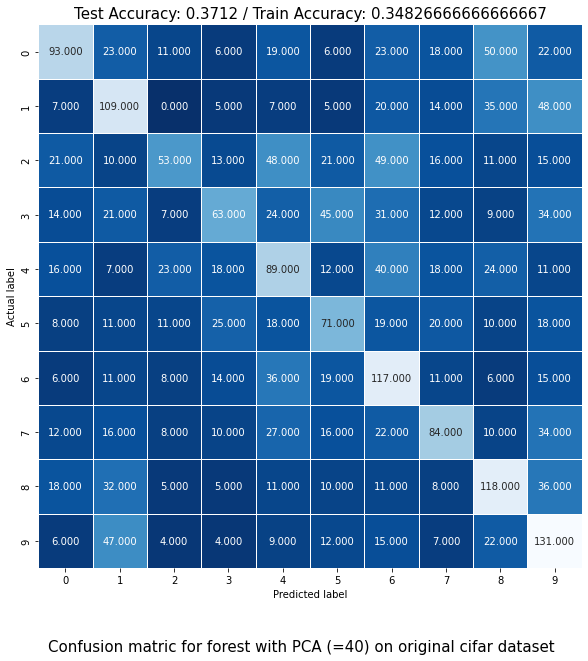


 ------- Reconstructed Image ----------------
0.3408 0.3664


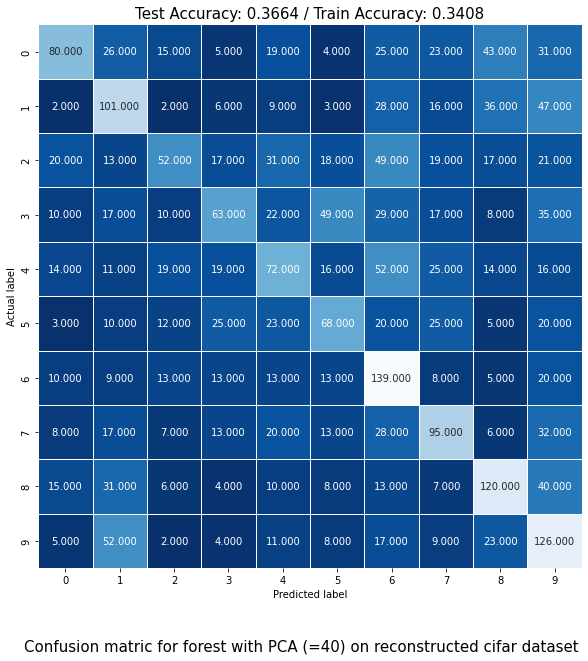


 ------- Reconstructed Non-fourier Image ----------------
0.3252 0.3468


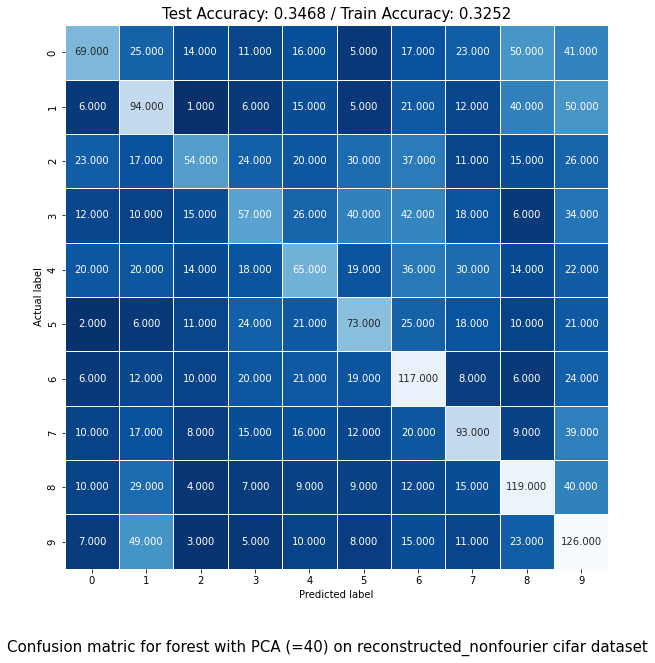

0

In [49]:
pca_features = 40

print( "------- Original Image ----------------")
classifier(input_org,targets,'forest',"original "+dataset_name,True,pca_features)
print("\n", "------- Reconstructed Image ----------------")
classifier(input_reconst,targets,'forest',"reconstructed "+dataset_name,True,pca_features)
print("\n", "------- Reconstructed Non-fourier Image ----------------")
classifier(input_reconst_nonfourier,targets_nonfourier,'forest',"reconstructed_nonfourier "+dataset_name,True,pca_features)

## NN Classifier

In [68]:
def dataset_loader(input_array,labels):

  if dataset_name == "mnist":
    mnist_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1.0),
    transforms.CenterCrop((28))
    ])

    print("Write something for here.")
    # dataset = datasets.MNIST(root=os.path.join(d_path,'datasets'), train=True,download=False, transform=mnist_trans)


  if dataset_name == "cifar":
    cifar_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(0, 1.0),
    transforms.CenterCrop((28))
    ])

  X_train, X_test, y_train, y_test = train_test_split(input_array, labels, test_size=0.33, random_state=42)

  train_dataset = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).to(torch.long))
  test_dataset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).to(torch.long))
  
  input_dim = X_train.shape[1]
  return input_dim,DataLoader(train_dataset, batch_size=32,num_workers=2),DataLoader(test_dataset, batch_size=32, num_workers=2)

In [69]:
input_dimension,train_dataloader,test_dataloader = dataset_loader(input_reconst,targets)

In [70]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [71]:
class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512) # input has 4 dimensions.
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512,10)

    def forward(self, x):
        # x = x.view(-1,4) # input has 4 dimensions.
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        x = self.fc3(x)
        return x

In [72]:
model = Net(input_dimension).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [81]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):

        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


# print(inputs,"\n",labels,"\n",outputs)
# print(outputs.dtype,labels.dtype)
print('Finished Training')

[1,     1] loss: 0.854
[1,   101] loss: 60.380
[1,   201] loss: 69.301
[2,     1] loss: 0.977
[2,   101] loss: 69.824
[2,   201] loss: 69.872
Finished Training


In [80]:
correct = 0.
total = 0.
for inputs, labels in train_dataloader:

    inputs = inputs.to(device)
    outputs_test = model(inputs)
    _, predicted = torch.max(outputs_test.data, 1)
    #print(predicted)
    total += labels.size(0)

    correct += (predicted.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (     100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


## Reconstruction loss


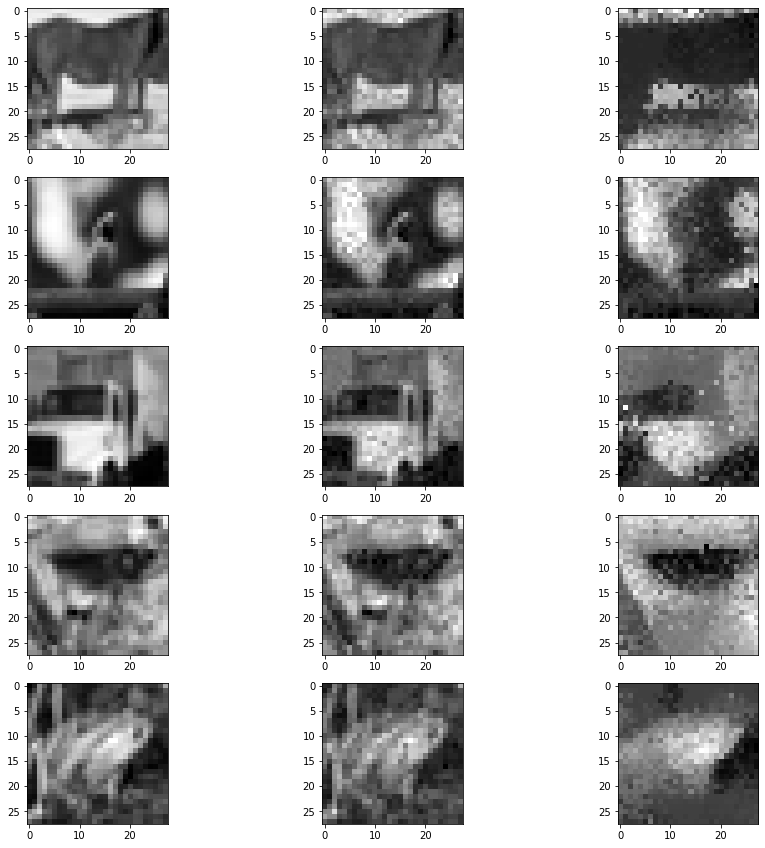

In [44]:
f, axarr = plt.subplots(5,3,figsize=(15,15))

for i,idx in enumerate(np.linspace(0, 9999, 5,dtype=int)):

    axarr[i,0].imshow(input_org_reshape[idx],cmap="gray")
    axarr[i,1].imshow(input_reconst[idx],cmap="gray")
    axarr[i,2].imshow(input_reconst_nonfourier[idx],cmap="gray")

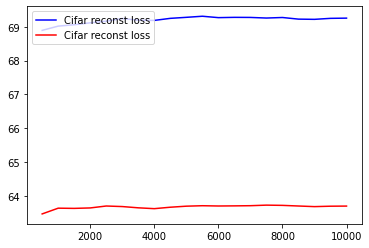

In [45]:
# Plot psnr losses over a range over increasing interval of data

psnr_losses_cifar = []
psnr_losses_cifar_nonfourier = []

for i in range(500,10001,500):
    psnr_losses_cifar.append(cv2.PSNR(input_reconst[:i],input_org_reshape[:i]))
    psnr_losses_cifar_nonfourier.append(cv2.PSNR(input_reconst_nonfourier[:i],input_org_reshape[:i]))


plt.plot(np.arange(500,10001,500),psnr_losses_cifar, "-b",label = 'Cifar reconst loss')
plt.plot(np.arange(500,10001,500),psnr_losses_cifar_nonfourier, "-r",label = 'Cifar reconst loss')
plt.legend(loc="upper left")
plt.show()

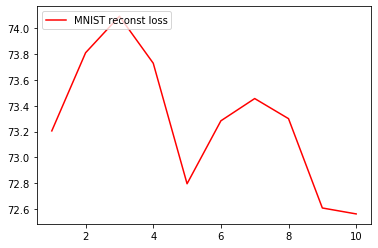

In [51]:
# Plot psnr losses over a range over increasing interval of data
# Need to reconstruct MNist images

psnr_losses_mnist = []

for i in range(0,10000,500):
    psnr_losses_mnist.append(cv2.PSNR(input_reconst[:i],input_org_reshape[:i]))

plt.plot(np.arange(0,10000,500),psnr_losses_mnist, "-r",label = 'MNIST reconst loss')
plt.legend(loc="upper left")
plt.show()

In [52]:
np.average(psnr_losses_mnist)

73.28430239409337